In [1]:
## Import libraries that will be used

import sagemaker
import os
import pandas as pd
import numpy as np
import boto3
import json
import io
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer
from scipy.sparse import csr_matrix

- S3 Bucket
- IAM role and data permission

In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
base = 'DEMO-loft-recommender'
prefix = 'sagemaker/' + base
role = sagemaker.get_execution_role()

Make a directory and download dataset into the directory

In [3]:
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz /tmp/recsys/

download: s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz to ../../../tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz


In [4]:
df = pd.read_csv('/tmp/recsys/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', delimiter='\t', error_bad_lines=False)
df.head()

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


- Select column to use
- Most customers and products didn't and wern't be reviewd

In [5]:
df = df[['customer_id', 'product_id', 'product_title', 'star_rating', 'review_date']]
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.00       1.0
0.01       1.0
0.02       1.0
0.03       1.0
0.04       1.0
0.05       1.0
0.10       1.0
0.25       1.0
0.50       1.0
0.75       2.0
0.90       4.0
0.95       5.0
0.96       6.0
0.97       7.0
0.98       9.0
0.99      13.0
1.00    2704.0
Name: customer_id, dtype: float64
products
 0.00        1.00
0.01        1.00
0.02        1.00
0.03        1.00
0.04        1.00
0.05        1.00
0.10        1.00
0.25        1.00
0.50        3.00
0.75        9.00
0.90       31.00
0.95       73.00
0.96       95.00
0.97      130.00
0.98      199.00
0.99      386.67
1.00    32790.00
Name: product_id, dtype: float64


- Let customers and products that have enough sample left
- Replace white space with a special character to be seen as single words

In [6]:
customers = customers[customers >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id':products.index}))
reduced_df['product_title'] = reduced_df['product_title'].apply(lambda x: x.lower().replace(' ', '-'))

- Save purchase lists grouped by customer to a file

In [8]:
with open('customer_purchases.txt', 'w') as f:
    for customer, data in reduced_df.sort_values(['customer_id', 'review_date']).groupby('customer_id'):
        f.write(' '.join(data['product_title'].tolist()))
        f.write('\n')

- Give the data to s3

In [12]:
inputs = sess.upload_data('customer_purchases.txt',bucket,'{}/word2vec/train'.format(prefix))

Sagemaker estimator

In [13]:
bt = sagemaker.estimator.Estimator(
    sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'blazingtext', 'latest'),
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path='s3://{}/{}/output'.format(bucket,prefix),
    sagemaker_session=sess
    )

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


Set hyperparameter 

In [14]:
bt.set_hyperparameters(mode='skipgram', 
                       epochs=10,
                       min_count=5,
                       sampling_threshold=0.0001,
                       learning_rate=0.05,
                       window_size=5,
                       vector_dim=100,
                       negative_samples=5,
                       min_char=5,
                       max_char=10,
                       evaluation=False,
                       subwords=True
                       )

In [44]:
bt.fit({'train': sagemaker.inputs.TrainingInput(inputs, distribution='FullyReplicated', content_type='text/csv')})

2022-02-26 21:15:43 Starting - Starting the training job...
2022-02-26 21:16:06 Starting - Launching requested ML instancesProfilerReport-1645910143: InProgress
......
2022-02-26 21:17:14 Starting - Preparing the instances for training.........
2022-02-26 21:18:41 Downloading - Downloading input data...
2022-02-26 21:19:07 Training - Downloading the training image...
2022-02-26 21:19:33 Training - Training image download completed. Training in progress....Arguments: train
[02/26/2022 21:19:35 WARNING 139952849982848] Loggers have already been setup.
[02/26/2022 21:19:35 WARNING 139952849982848] Loggers have already been setup.
[02/26/2022 21:19:35 INFO 139952849982848] nvidia-smi took: 0.025273799896240234 secs to identify 0 gpus
[02/26/2022 21:19:35 INFO 139952849982848] Running single machine CPU BlazingText training using skipgram mode.
Number of CPU sockets found in instance is  1
[02/26/2022 21:19:35 INFO 139952849982848] Processing /opt/ml/input/data/train/customer_purchases.txt 

In [45]:
!aws s3 cp $bt.model_data ./

download: s3://sagemaker-us-east-1-220121537131/sagemaker/DEMO-loft-recommender/output/blazingtext-2022-02-26-21-15-43-198/output/model.tar.gz to ./model.tar.gz


In [46]:
!tar -xvzf model.tar.gz

vectors.bin
vectors.txt


In [47]:
vectors = pd.read_csv('vectors.txt', delimiter=' ', skiprows=2, header = None)

In [62]:
vectors.sort_values(10)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
8940,"agatha-christie's-poirot,-series-9",0.939600,-0.187640,-0.022948,0.22454,0.52265,-0.065325,0.52970,0.530780,-0.331600,...,0.494020,-1.001800,0.852510,0.025810,0.359460,1.179000,-0.327580,-0.66326,-1.232700,NaN
11750,"agatha-christie's-poirot,-series-10",0.889710,-0.149430,-0.082990,0.13140,0.58044,-0.054060,0.66680,0.569760,-0.359900,...,0.490120,-1.124200,0.744530,0.094117,0.467390,1.061900,-0.153900,-0.55555,-1.200600,NaN
6956,samurai-girls-season-1,0.108840,-0.023934,0.369630,-0.51921,0.15740,0.025867,-0.18290,-0.645430,0.231310,...,-0.174570,0.142330,-0.193070,0.428360,-0.431590,-0.211700,0.035379,-0.29480,0.222510,NaN
5850,"agatha-christie's-poirot,-series-13",0.887860,-0.187300,-0.077438,0.19132,0.60124,-0.036947,0.61149,0.505080,-0.352610,...,0.496500,-1.080000,0.772250,0.051923,0.450420,1.087500,-0.190190,-0.54106,-1.229000,NaN
17682,lost-christmas,0.245690,-0.572970,0.285240,0.70138,0.38845,-0.335630,1.17820,0.228920,-0.039546,...,0.138650,0.423850,0.054680,0.664180,-0.092621,0.903010,0.131470,-1.36530,-0.070453,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4761,survivor:--season-18,0.285270,0.932600,-0.204940,-0.65285,0.33653,-0.388360,0.25108,-0.500920,-0.408310,...,-0.479450,-0.064790,0.162880,0.588330,-0.118320,0.383510,-0.221580,-1.56870,0.483730,NaN
7173,friday-night-lights,-0.183850,0.169870,-0.615060,-0.67185,0.45813,0.254430,-0.24004,0.836840,-0.183520,...,-0.303910,0.712830,0.308970,-0.445480,-0.164840,0.855530,0.173560,-0.54523,0.753010,NaN
7313,survivor:-season-19,0.151400,0.669540,-0.431170,-0.59946,0.63270,-0.420500,0.24864,-0.217310,-0.462540,...,-0.497520,0.056035,0.109730,0.269860,-0.068517,0.129190,-0.007764,-1.64290,0.561130,NaN
1356,into-the-wild,0.007895,0.098771,0.654170,-0.35577,0.92833,-0.673190,1.00730,0.485620,0.341070,...,0.118450,-0.270500,-0.057324,-0.120070,-0.349460,0.282700,-0.087693,0.19872,0.294740,NaN


In [64]:
product_titles = vectors[0]
vectors = vectors.drop([0, 101], axis=1)

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
embeddings = tsne.fit_transform(vectors.values[:100, ])

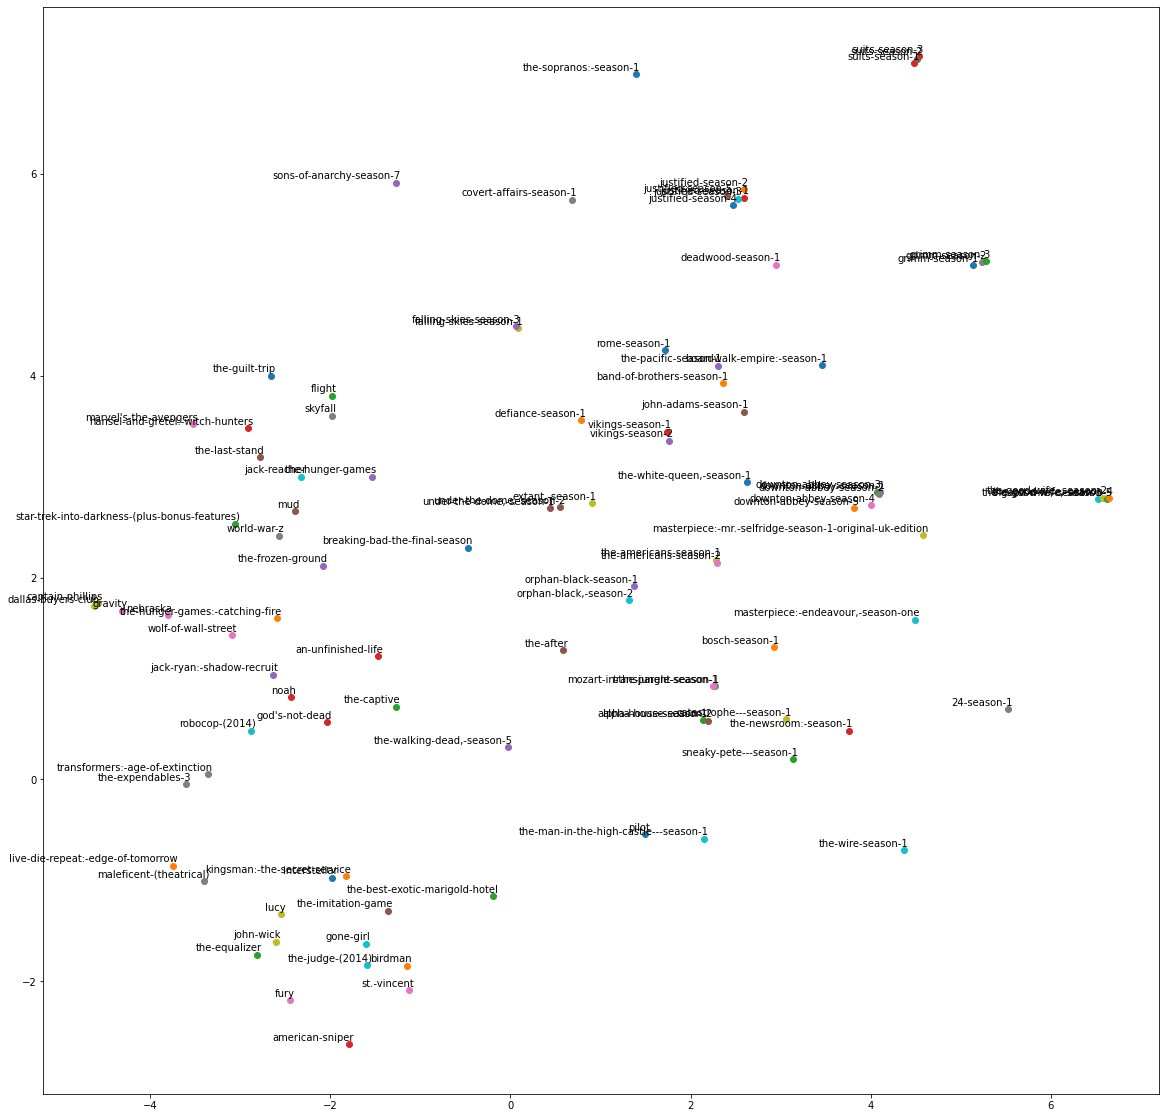

In [66]:
from matplotlib import pylab
%matplotlib inline
def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points',
                      ha='right', va='bottom')
    pylab.show()

plot(embeddings, product_titles[:100])

In [67]:
bt_endpoint = bt.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------!

In [68]:
from sagemaker.serializers import JSONSerializer
bt_endpoint.serializer = JSONSerializer()

In [69]:
words = ["sherlock-season-1",
         "sherlock-season-2",
         "sherlock-season-5",
         "arbitrary-sherlock-holmes-string",
         "the-imitation-game",
         "abcdefghijklmn",
         "keeping-up-with-the-kardashians-season-1"]
payload = {"instances" : words}
response = bt_endpoint.predict(payload)
vecs_df = pd.DataFrame(json.loads(response))

In [70]:
vecs_df = pd.DataFrame(vecs_df['vector'].values.tolist(), index=vecs_df['word'])
vecs_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
word,,,,,,,,,,,,,,,,,,,,,
sherlock-season-1,0.043393,-0.217396,-0.189047,0.082751,0.487272,-0.412123,0.408519,0.047735,-0.056351,-0.051717,...,-0.082140,0.053553,-0.422838,-0.114946,0.182403,0.264680,-0.111176,-0.146286,-0.018968,0.073572
sherlock-season-2,0.118879,-0.156278,-0.188293,0.177609,0.389141,-0.473809,0.396962,0.067571,-0.024059,-0.012688,...,-0.075289,0.150523,-0.290186,0.040782,0.092326,0.122837,-0.142535,-0.103687,0.057954,0.171768
sherlock-season-5,0.188648,-0.089764,-0.095910,0.306101,0.367257,-0.504445,0.639008,-0.104736,-0.177232,0.093621,...,-0.003489,0.071056,-0.227269,0.122648,0.218642,0.164119,-0.026210,-0.105877,0.013575,0.163360
arbitrary-sherlock-holmes-string,0.465312,-0.111222,-0.044617,-0.224462,0.024406,-0.404681,0.140864,0.150736,-0.089363,-0.409682,...,-0.246188,0.163257,-0.540923,0.064907,-0.003641,-0.035007,0.106406,-0.261859,0.114429,-0.510645
the-imitation-game,0.325083,-0.192158,0.519636,0.211631,0.264785,-0.056425,-0.217032,-0.144014,0.059277,-0.042595,...,0.070311,0.311291,-0.067739,-0.017638,-0.403573,-0.190514,-0.025126,-0.283166,-0.249961,0.045190
abcdefghijklmn,0.039069,0.034308,0.033110,-0.041163,0.027240,-0.025687,0.047830,-0.049021,-0.014764,0.001795,...,0.005307,0.024439,-0.011876,-0.021268,-0.004694,0.012958,-0.019209,0.023065,-0.027583,0.003796
keeping-up-with-the-kardashians-season-1,0.575181,0.208632,-0.237527,-0.446194,-0.166132,-0.481970,0.505854,0.091509,0.052939,-0.074712,...,-0.052476,-0.467106,-0.218226,0.094907,0.108655,-0.066126,-0.274865,-0.233361,-0.751767,0.320870


In [71]:
vecs_df = vecs_df.transpose()
vecs_df.corr()

word,sherlock-season-1,sherlock-season-2,sherlock-season-5,arbitrary-sherlock-holmes-string,the-imitation-game,abcdefghijklmn,keeping-up-with-the-kardashians-season-1
word,,,,,,,
sherlock-season-1,1.000000,0.958489,0.903891,0.536900,0.296168,0.186592,0.074034
sherlock-season-2,0.958489,1.000000,0.927430,0.548610,0.304084,0.184748,0.078260
sherlock-season-5,0.903891,0.927430,1.000000,0.574174,0.343322,0.162414,0.140282
arbitrary-sherlock-holmes-string,0.536900,0.548610,0.574174,1.000000,0.344397,0.000481,0.041446
the-imitation-game,0.296168,0.304084,0.343322,0.344397,1.000000,0.335819,0.197944
abcdefghijklmn,0.186592,0.184748,0.162414,0.000481,0.335819,1.000000,0.403985
keeping-up-with-the-kardashians-season-1,0.074034,0.078260,0.140282,0.041446,0.197944,0.403985,1.000000


In [72]:
for column in vecs_df.columns:
    print(column + ':', np.sum(vecs_df[column] - vecs_df['sherlock-season-1'] ** 2))

sherlock-season-1: -10.844993347271485
sherlock-season-2: -9.364788571342034
sherlock-season-5: -10.113841951095639
arbitrary-sherlock-holmes-string: -13.408724064500676
the-imitation-game: -11.21842978670462
abcdefghijklmn: -11.385217024914128
keeping-up-with-the-kardashians-season-1: -12.17030125480811
